# Нейросетевая классификация текстов

Решим задачу классификации текстов из датасета [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import copy
seaborn.set(palette='summer')

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from sklearn.metrics import (
                              f1_score,
                              precision_recall_curve,
                              precision_score,
                              recall_score,
                              classification_report
)

from collections import Counter
from typing import List
import string

In [3]:
np.random.seed(42)

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [7]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [8]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']}

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256
) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [9]:
train_dataset = WordDataset(dataset['train'])

idx = np.random.choice(np.arange(len(dataset['test'])), 10000)
eval_dataset = WordDataset(dataset['test'].select(idx[:5000]))
test_dataset = WordDataset(dataset['test'].select(idx[5000:]))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Для оценки качества модели, будем использовать `eval_dataloader`. Ниже приведена функция, которую необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [10]:
# сбор статистики моделей
models_stats = {}

In [11]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
- Сперва создадим и обучим модель, которую будем использовать в качестве бейзлайна.
- Проведем эксперименты по её улучшению.
- Оценим результаты

## Baseline

### Model

In [12]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output)) # [batch_size, num_classes]

        return prediction

### Train loop

In [13]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    optimizer,
    criterion: torch.nn = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']),
    num_epoch: int = 5,
    eval_steps: int = len(train_dataloader) // 2,
):
    num_epoch = num_epoch
    eval_steps = eval_steps

    losses_type = {}
    acc_type = {}
    losses = []
    acc = []

    model = model.to(device)
    criterion = criterion
    optimizer = optimizer

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, acc

In [14]:
aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type)
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [15]:
def loss_acc_plot(losses_type, acc_type):
    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    for (name, values), color in zip(acc_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

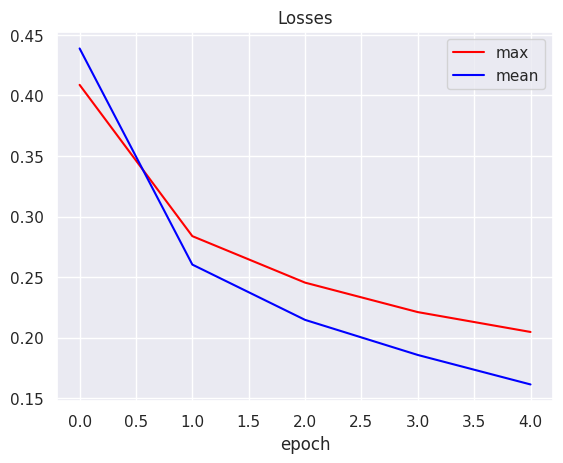

Лучшая accuracy для подхода max: 90.02
Лучшая accuracy для подхода mean: 91.00


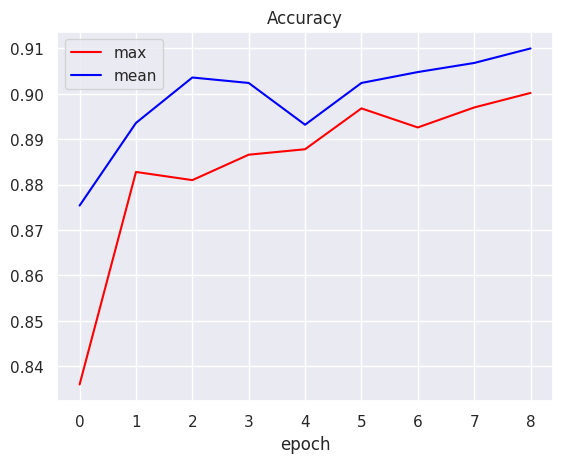

In [16]:
loss_acc_plot(losses_type, acc_type)

In [17]:
model_name = model.__class__.__name__ + '_max'
models_stats[str(model_name)] = np.mean(acc_type['max'])

model_name = model.__class__.__name__ + '_mean'
models_stats[str(model_name)] = np.mean(acc_type['mean'])

## General funcs

In [18]:
def cnt_params(model):
  """
  Function for calculating model parameters.
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
# для проверки метрик: precision, recall, f1
LABEL_NAMES =  ["World", "Sports", "Business", "Sci/Tech"]
def make_metrics(model, test_dataloader, name_mod, label_names=LABEL_NAMES):
    """
    Test for precision, recall, f1.
    """
    model.eval()
    y_pred = []
    y_true = []
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False)
    for _, batch in pbar:
        logits = model(batch['input_ids'])
        y_pred.append(logits.argmax(dim=1).to('cpu'))
        y_true.append(batch['label'].to('cpu'))

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    mean_accuracy = (y_pred == y_true).float().mean().item()
    if name_mod:
        model_name = f'{model.__class__.__name__}_{name_mod}'
    else:
        model_name = f'{model.__class__.__name__}'
    models_stats[model_name] = mean_accuracy
    print(f'Mean accuracy: {mean_accuracy}')
    print(classification_report(y_true, y_pred, target_names=label_names))

In [20]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    optimizer,
    criterion: torch.nn = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']),
    num_epoch: int = 42,
    max_grad_norm: int = 1,
    patience: int = 5,
    aggregation_type: str = 'max'
):
    num_epoch = num_epoch
    patience_count = 0
    best_val_loss = np.inf

    losses = []
    acc = []

    model = model.to(device)
    criterion = criterion
    optimizer = optimizer

    best_model = copy.deepcopy(model.state_dict())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            epoch_losses.append(loss.item())

        val_loss = 0.0
        num_iter = 0
        model.eval()
        predictions = []
        target = []
        with torch.no_grad():
            for i, batch in enumerate(tqdm(eval_dataloader, desc=f'Val epoch {epoch}:')):
                logits = model(batch['input_ids'])
                predictions.append(logits.argmax(dim=1))
                target.append(batch['label'])
                num_iter += 1
                val_loss += criterion(logits, batch['label'])

        valid_loss = val_loss / num_iter
        predictions = torch.cat(predictions)
        target = torch.cat(target)
        accuracy = (predictions == target).float().mean().item()
        acc.append(accuracy)
        losses.append(sum(epoch_losses) / len(epoch_losses))

        print(f"Valid Loss: {valid_loss:.4f}, accuracy: {accuracy:.4f}")

        if (best_val_loss > valid_loss):
            patience_count = 0
            best_val_loss = valid_loss
            best_model = copy.deepcopy(model.state_dict())
        if patience is not None:
            if (patience_count > patience):
                break
            patience_count += 1

    model.load_state_dict(best_model)
    if aggregation_type:
        torch.save(best_model, f'/content/{model.__class__.__name__}_{aggregation_type}')
    else:
        torch.save(best_model, f'/content/{model.__class__.__name__}')
    mean_acc = np.mean(acc)
    print(f"Средняя по эпохам Accuracy - {mean_acc:.2f}")

    return losses, acc

## RNN

### Simple LSTM

In [21]:
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size: int, output_dim: int, embedding_dim: int,
                 hidden_dim: int, num_layers: int, dropout: float, pad_idx: int,
                 aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.projection = nn.Linear(hidden_dim, output_dim)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.linear(self.tanh(output))
        prediction = self.projection(self.tanh(output))

        return prediction

In [22]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleLSTM(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 4151300 обучаемых параметров


In [23]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleLSTM(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2730, accuracy: 0.9122


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2633, accuracy: 0.9136


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2618, accuracy: 0.9144


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2953, accuracy: 0.9110


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3481, accuracy: 0.9110


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3625, accuracy: 0.9108


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3934, accuracy: 0.9110


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4464, accuracy: 0.9066


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4594, accuracy: 0.9072
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2776, accuracy: 0.9140


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2558, accuracy: 0.9182


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2600, accuracy: 0.9146


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3035, accuracy: 0.9106


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3491, accuracy: 0.9136


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3928, accuracy: 0.9114


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4566, accuracy: 0.9158


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4871, accuracy: 0.9132
Средняя по эпохам Accuracy - 0.91


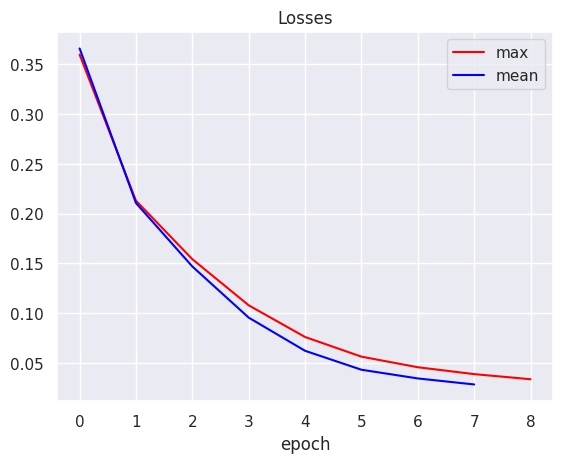

Лучшая accuracy для подхода max: 91.44
Лучшая accuracy для подхода mean: 91.82


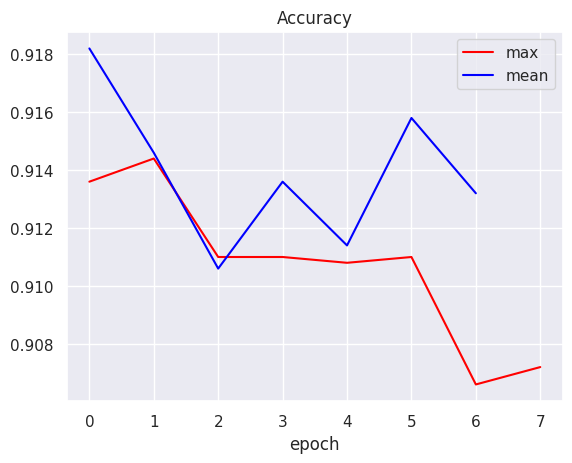

In [24]:
loss_acc_plot(losses_type, acc_type)

In [25]:
model = SimpleLSTM(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleLSTM_max", "/content/SimpleLSTM_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='simple_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleLSTM_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9132000207901001
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1270
      Sports       0.95      0.98      0.97      1206
    Business       0.89      0.89      0.89      1259
    Sci/Tech       0.89      0.89      0.89      1265

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000


Classification report for SimpleLSTM_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.853600025177002
              precision    recall  f1-score   support

       World       0.75      0.94      0.84      1270
      Sports       0.96      0.87      0.92      1206
    Business       0.87      0.73      0.79      1259
    Sci/Tech       0.87      0.87      0.87      1265

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000




### LSTM: 4 layers

In [26]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleLSTM(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 5203972 обучаемых параметров


In [27]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleLSTM(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2913, accuracy: 0.9040


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2720, accuracy: 0.9140


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2703, accuracy: 0.9138


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2823, accuracy: 0.9158


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3221, accuracy: 0.9116


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3200, accuracy: 0.9114


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3853, accuracy: 0.9054


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4221, accuracy: 0.9048


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4446, accuracy: 0.8978
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3230, accuracy: 0.8956


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2813, accuracy: 0.9102


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2892, accuracy: 0.9084


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3337, accuracy: 0.9094


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3635, accuracy: 0.9048


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3805, accuracy: 0.9034


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4358, accuracy: 0.8948


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4711, accuracy: 0.9026
Средняя по эпохам Accuracy - 0.90


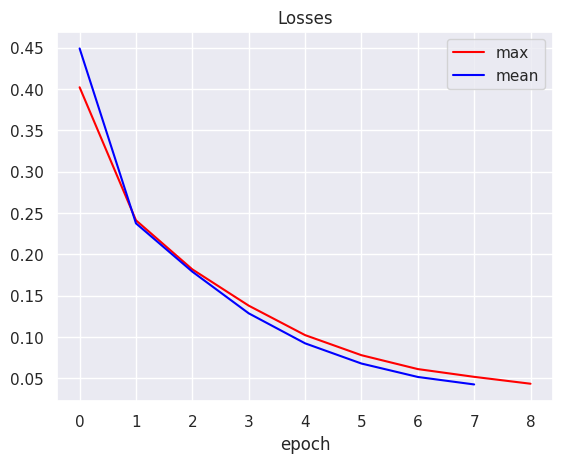

Лучшая accuracy для подхода max: 91.58
Лучшая accuracy для подхода mean: 91.02


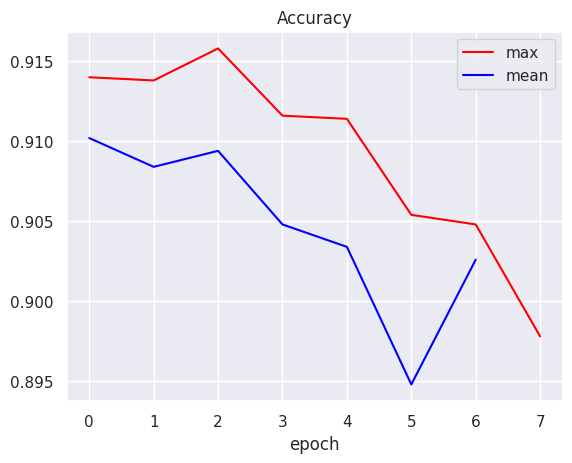

In [28]:
loss_acc_plot(losses_type, acc_type)

In [29]:
model = SimpleLSTM(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleLSTM_max", "/content/SimpleLSTM_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='4layers_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleLSTM_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9107999801635742
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1270
      Sports       0.93      0.98      0.96      1206
    Business       0.87      0.90      0.89      1259
    Sci/Tech       0.91      0.86      0.88      1265

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000


Classification report for SimpleLSTM_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.7838000059127808
              precision    recall  f1-score   support

       World       0.69      0.93      0.79      1270
      Sports       0.98      0.73      0.84      1206
    Business       0.86      0.54      0.66      1259
    Sci/Tech       0.74      0.93      0.82      1265

    accuracy                           0.78      5000
   macro avg       0.82      0.78      0.78      5000
weighted avg       0.81      0.78      0.78      5000




### LSTM bidirectional

In [30]:
class SimpleLSTMBidirectional(nn.Module):
    def __init__(self, vocab_size: int, output_dim: int, embedding_dim: int,
                hidden_dim: int, num_layers: int, dropout: float, pad_idx: int,
                aggregation_type: str = 'max', bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            dropout=dropout, batch_first=True,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.tanh = nn.Tanh()
        self.projection = nn.Linear(hidden_dim, output_dim)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.linear(self.tanh(output))
        prediction = self.projection(self.tanh(output))

        return prediction

In [31]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleLSTMBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 5793796 обучаемых параметров


In [32]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleLSTMBidirectional(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2857, accuracy: 0.9016


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2662, accuracy: 0.9126


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2703, accuracy: 0.9084


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2862, accuracy: 0.9136


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3432, accuracy: 0.9056


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3600, accuracy: 0.9082


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4102, accuracy: 0.9072


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4521, accuracy: 0.8986
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2772, accuracy: 0.9082


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2550, accuracy: 0.9102


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2738, accuracy: 0.9136


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2886, accuracy: 0.9030


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3856, accuracy: 0.9068


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4280, accuracy: 0.9094


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4720, accuracy: 0.9062


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4907, accuracy: 0.9080
Средняя по эпохам Accuracy - 0.91


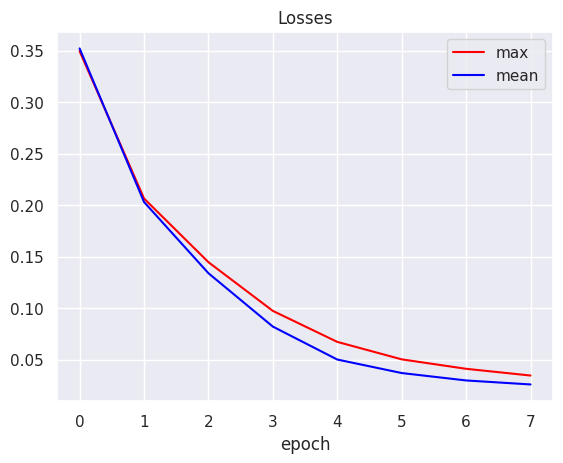

Лучшая accuracy для подхода max: 91.36
Лучшая accuracy для подхода mean: 91.36


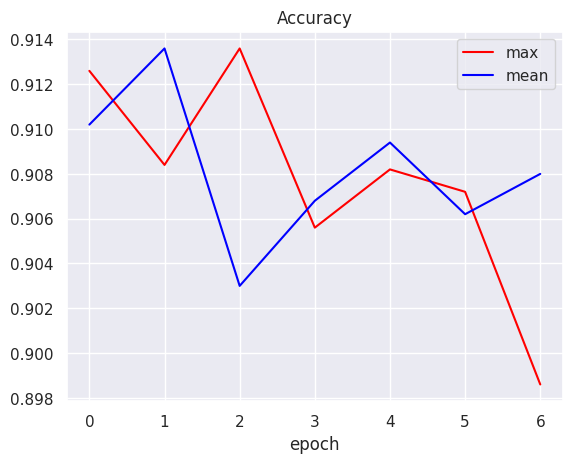

In [33]:
loss_acc_plot(losses_type, acc_type)

In [34]:
model = SimpleLSTMBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleLSTMBidirectional_max", "/content/SimpleLSTMBidirectional_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='bidir_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleLSTMBidirectional_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9193999767303467
              precision    recall  f1-score   support

       World       0.93      0.92      0.92      1270
      Sports       0.95      0.98      0.97      1206
    Business       0.88      0.91      0.90      1259
    Sci/Tech       0.92      0.87      0.89      1265

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000


Classification report for SimpleLSTMBidirectional_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.8830000162124634
              precision    recall  f1-score   support

       World       0.89      0.87      0.88      1270
      Sports       0.96      0.96      0.96      1206
    Business       0.84      0.82      0.83      1259
    Sci/Tech       0.85      0.88      0.87      1265

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000




### LSTM: bidirectional, 4 layers

In [35]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleLSTMBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 8947716 обучаемых параметров


In [36]:
aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleLSTMBidirectional(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3009, accuracy: 0.9044


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2638, accuracy: 0.9116


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2585, accuracy: 0.9198


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2856, accuracy: 0.9142


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2972, accuracy: 0.9156


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3219, accuracy: 0.9130


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3655, accuracy: 0.9154


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3595, accuracy: 0.9088


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3780, accuracy: 0.9114
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3095, accuracy: 0.9006


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2736, accuracy: 0.9124


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2758, accuracy: 0.9106


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3097, accuracy: 0.9122


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3393, accuracy: 0.9104


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4270, accuracy: 0.9062


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4334, accuracy: 0.9060


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4526, accuracy: 0.9046
Средняя по эпохам Accuracy - 0.91


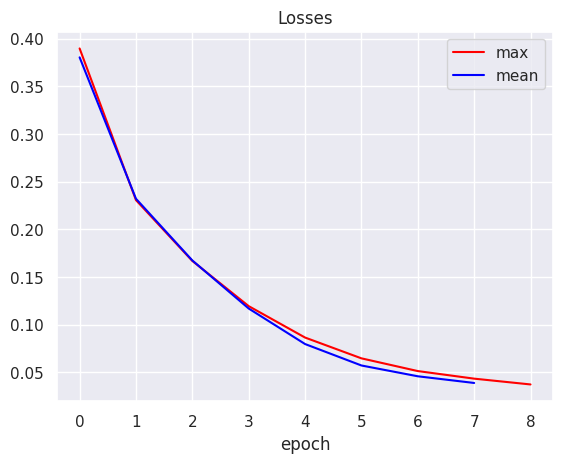

Лучшая accuracy для подхода max: 91.98
Лучшая accuracy для подхода mean: 91.24


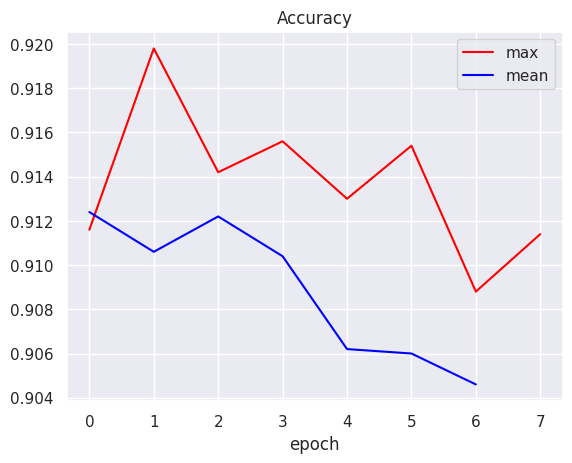

In [37]:
loss_acc_plot(losses_type, acc_type)

In [38]:
model = SimpleLSTMBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleLSTMBidirectional_max", "/content/SimpleLSTMBidirectional_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='bidir_4layers_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleLSTMBidirectional_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9156000018119812
              precision    recall  f1-score   support

       World       0.94      0.91      0.92      1270
      Sports       0.95      0.98      0.97      1206
    Business       0.91      0.87      0.89      1259
    Sci/Tech       0.87      0.90      0.89      1265

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000


Classification report for SimpleLSTMBidirectional_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.6592000126838684
              precision    recall  f1-score   support

       World       0.72      0.64      0.68      1270
      Sports       0.98      0.53      0.69      1206
    Business       0.83      0.48      0.61      1259
    Sci/Tech       0.50      0.97      0.66      1265

    accuracy                           0.66      5000
   macro avg       0.76      0.66      0.66      5000
weighted avg       0.75      0.66      0.66      5000




## GRU

### SimpleGRU

In [39]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size: int, output_dim: int, embedding_dim: int,
                hidden_dim: int, num_layers: int, dropout: float, pad_idx: int,
                aggregation_type: str = 'max', bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            dropout=dropout, batch_first=True,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.projection = nn.Linear(hidden_dim, output_dim)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.linear(self.tanh(output))
        prediction = self.projection(self.tanh(output))

        return prediction

In [40]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleGRU(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 4151300 обучаемых параметров


In [41]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleGRU(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2788, accuracy: 0.9052


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2553, accuracy: 0.9172


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2619, accuracy: 0.9214


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2670, accuracy: 0.9208


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3155, accuracy: 0.9114


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3682, accuracy: 0.9120


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3809, accuracy: 0.9120


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4556, accuracy: 0.9084
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2802, accuracy: 0.9054


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2634, accuracy: 0.9134


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2855, accuracy: 0.9140


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3209, accuracy: 0.9098


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3564, accuracy: 0.9092


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4452, accuracy: 0.9084


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4908, accuracy: 0.9060


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.5109, accuracy: 0.9100
Средняя по эпохам Accuracy - 0.91


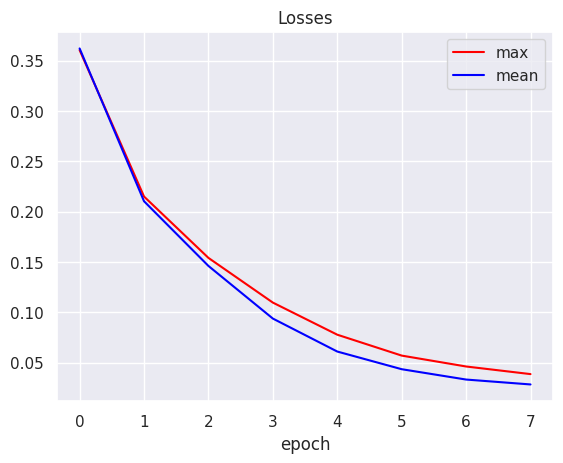

Лучшая accuracy для подхода max: 92.14
Лучшая accuracy для подхода mean: 91.40


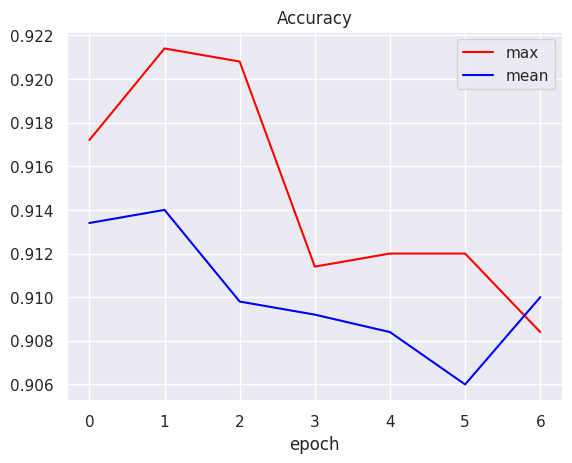

In [42]:
loss_acc_plot(losses_type, acc_type)

In [43]:
model = SimpleGRU(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleGRU_max", "/content/SimpleGRU_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='simple_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleGRU_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9124000072479248
              precision    recall  f1-score   support

       World       0.93      0.90      0.92      1270
      Sports       0.95      0.98      0.96      1206
    Business       0.88      0.89      0.89      1259
    Sci/Tech       0.90      0.87      0.88      1265

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000


Classification report for SimpleGRU_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.8285999894142151
              precision    recall  f1-score   support

       World       0.96      0.59      0.73      1270
      Sports       0.90      0.97      0.94      1206
    Business       0.81      0.90      0.85      1259
    Sci/Tech       0.71      0.87      0.78      1265

    accuracy                           0.83      5000
   macro avg       0.85      0.83      0.82      5000
weighted avg       0.85      0.83      0.82      5000




### GRU: 4 layers

In [44]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleGRU(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 5203972 обучаемых параметров


In [45]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleGRU(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3197, accuracy: 0.8946


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2782, accuracy: 0.9118


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2801, accuracy: 0.9130


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2921, accuracy: 0.9130


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3402, accuracy: 0.9096


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3715, accuracy: 0.9062


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3977, accuracy: 0.9032


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4266, accuracy: 0.9034
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3062, accuracy: 0.9018


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2813, accuracy: 0.9126


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2765, accuracy: 0.9178


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3005, accuracy: 0.9118


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3171, accuracy: 0.9140


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3510, accuracy: 0.9074


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4004, accuracy: 0.9040


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4191, accuracy: 0.9092


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4193, accuracy: 0.9052
Средняя по эпохам Accuracy - 0.91


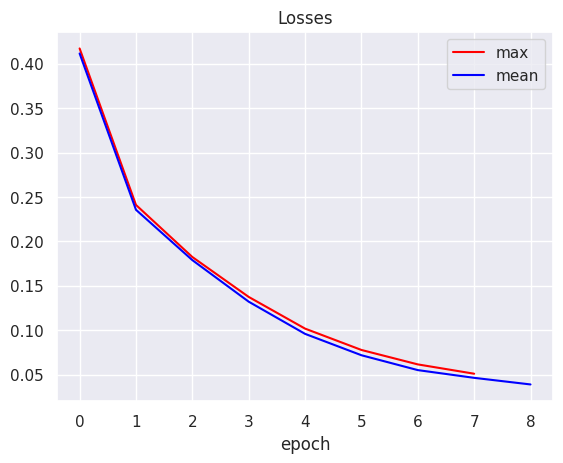

Лучшая accuracy для подхода max: 91.30
Лучшая accuracy для подхода mean: 91.78


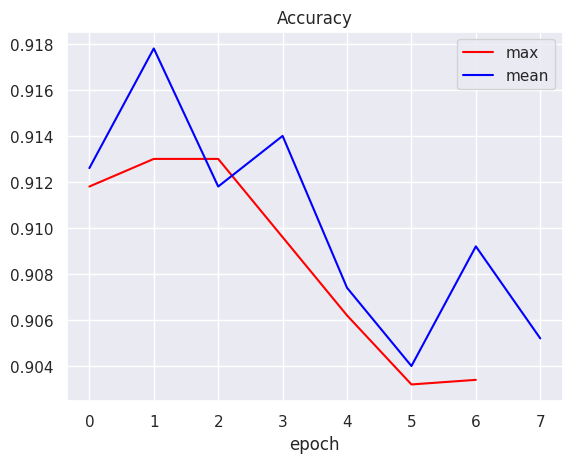

In [46]:
loss_acc_plot(losses_type, acc_type)

In [47]:
model = SimpleGRU(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleGRU_max", "/content/SimpleGRU_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='4layers_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleGRU_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9114000201225281
              precision    recall  f1-score   support

       World       0.94      0.89      0.91      1270
      Sports       0.95      0.97      0.96      1206
    Business       0.88      0.91      0.89      1259
    Sci/Tech       0.89      0.89      0.89      1265

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000


Classification report for SimpleGRU_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.756600022315979
              precision    recall  f1-score   support

       World       0.86      0.70      0.77      1270
      Sports       0.97      0.77      0.86      1206
    Business       0.90      0.59      0.71      1259
    Sci/Tech       0.56      0.97      0.71      1265

    accuracy                           0.76      5000
   macro avg       0.82      0.76      0.76      5000
weighted avg       0.82      0.76      0.76      5000




### GRU bidirectional

In [48]:
class SimpleGRUBidirectional(nn.Module):
    def __init__(self, vocab_size: int, output_dim: int, embedding_dim: int,
                hidden_dim: int, num_layers: int, dropout: float, pad_idx: int,
                aggregation_type: str = 'max', bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            dropout=dropout, batch_first=True,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.tanh = nn.Tanh()
        self.projection = nn.Linear(hidden_dim, output_dim)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.linear(self.tanh(output))
        prediction = self.projection(self.tanh(output))

        return prediction

In [49]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleGRUBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 5793796 обучаемых параметров


In [50]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 2
dropout = 0.2
PAD_IDX = word2ind['<pad>']

aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleGRUBidirectional(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2738, accuracy: 0.9072


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2715, accuracy: 0.9040


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2793, accuracy: 0.9088


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3354, accuracy: 0.9072


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3545, accuracy: 0.9078


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3759, accuracy: 0.9040


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4501, accuracy: 0.9064


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4575, accuracy: 0.9090
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2900, accuracy: 0.9046


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2534, accuracy: 0.9130


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2721, accuracy: 0.9146


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3076, accuracy: 0.9154


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3811, accuracy: 0.9080


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4504, accuracy: 0.9058


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.5048, accuracy: 0.9082


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.5036, accuracy: 0.9030
Средняя по эпохам Accuracy - 0.91


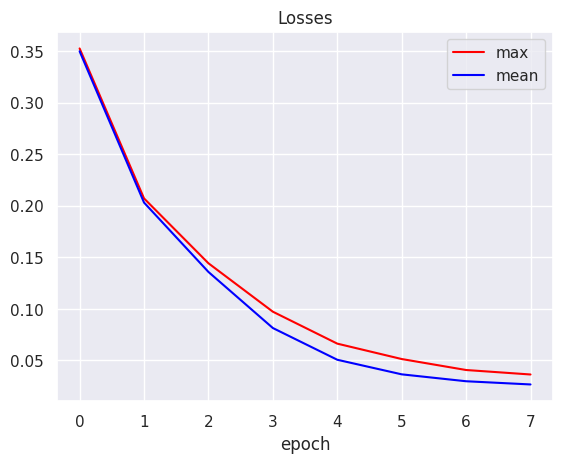

Лучшая accuracy для подхода max: 90.90
Лучшая accuracy для подхода mean: 91.54


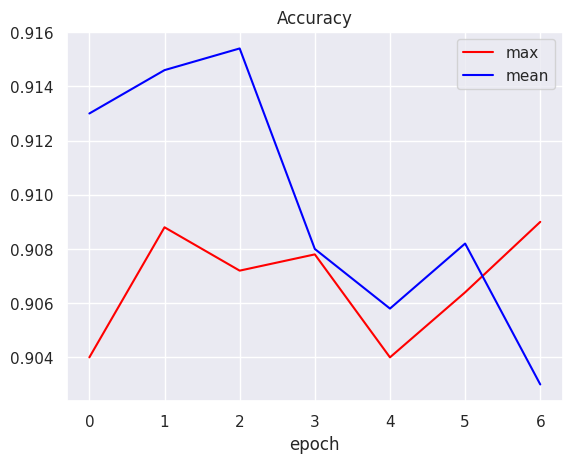

In [51]:
loss_acc_plot(losses_type, acc_type)

In [52]:
model = SimpleGRUBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleGRUBidirectional_max", "/content/SimpleGRUBidirectional_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='bidir_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleGRUBidirectional_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9169999957084656
              precision    recall  f1-score   support

       World       0.91      0.93      0.92      1270
      Sports       0.96      0.96      0.96      1206
    Business       0.91      0.88      0.90      1259
    Sci/Tech       0.89      0.90      0.90      1265

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000


Classification report for SimpleGRUBidirectional_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.8726000189781189
              precision    recall  f1-score   support

       World       0.94      0.84      0.89      1270
      Sports       0.91      0.98      0.94      1206
    Business       0.79      0.90      0.84      1259
    Sci/Tech       0.87      0.78      0.82      1265

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000




### GRU: bidirectional, 4 layers

In [53]:
# определяем гиперпараметры модели
vocab_size = len(vocab) + 1
emb_dim = 256
hidden_dim = 256
output_dim = 4
num_layers = 4
dropout = 0.2
PAD_IDX = word2ind['<pad>']

# создаем модель

model = SimpleGRUBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 8947716 обучаемых параметров


In [54]:
aggregation_types = ['max', 'mean']
losses_type = {}
acc_type = {}

# создаем модель
for aggregation_type in aggregation_types:
    print(f"Starting training for {aggregation_type}")
    model = SimpleGRUBidirectional(

            vocab_size=vocab_size,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            pad_idx=PAD_IDX,
            aggregation_type=aggregation_type

        )
    optimizer = torch.optim.Adam(model.parameters())

    losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=aggregation_type)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2899, accuracy: 0.9088


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2850, accuracy: 0.9056


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2756, accuracy: 0.9150


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2851, accuracy: 0.9134


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2943, accuracy: 0.9096


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3634, accuracy: 0.9046


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3833, accuracy: 0.9070


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3966, accuracy: 0.8926


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4282, accuracy: 0.9120
Средняя по эпохам Accuracy - 0.91
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2978, accuracy: 0.9028


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2743, accuracy: 0.9100


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2683, accuracy: 0.9130


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.2907, accuracy: 0.9154


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3455, accuracy: 0.9062


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3557, accuracy: 0.9068


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4022, accuracy: 0.9058


Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 7::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4321, accuracy: 0.9106


Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 8::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4324, accuracy: 0.9094
Средняя по эпохам Accuracy - 0.91


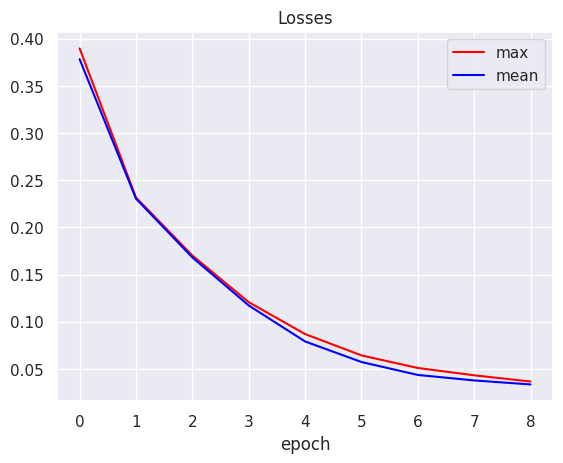

Лучшая accuracy для подхода max: 91.50
Лучшая accuracy для подхода mean: 91.54


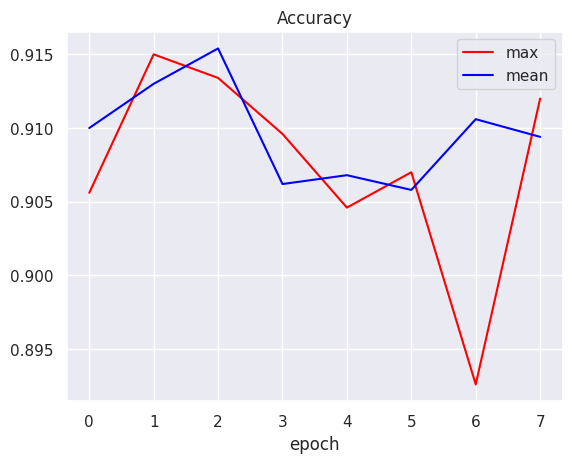

In [55]:
loss_acc_plot(losses_type, acc_type)

In [56]:
model = SimpleGRUBidirectional(

    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX

)

PATHS = ["/content/SimpleGRUBidirectional_max", "/content/SimpleGRUBidirectional_mean"]
for PATH in PATHS:
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    print('Classification report for {}'.format(PATH.split('/')[-1]))
    make_metrics(model, test_dataloader, name_mod='bidir_4layers_'+PATH.split('_')[-1])
    print('='*45)
    print()

Classification report for SimpleGRUBidirectional_max


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.9168000221252441
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1270
      Sports       0.95      0.98      0.96      1206
    Business       0.88      0.92      0.90      1259
    Sci/Tech       0.91      0.87      0.89      1265

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000


Classification report for SimpleGRUBidirectional_mean


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.6854000091552734
              precision    recall  f1-score   support

       World       0.77      0.60      0.68      1270
      Sports       0.98      0.56      0.71      1206
    Business       0.71      0.67      0.69      1259
    Sci/Tech       0.54      0.90      0.67      1265

    accuracy                           0.69      5000
   macro avg       0.75      0.68      0.69      5000
weighted avg       0.75      0.69      0.69      5000




## CNN

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень интересно" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Подгтовим данные и функции для обучения сверточной нейронной сети для задачи классификации текста

In [57]:
class TextCNN(nn.Module):
    def __init__(
            self,
            vocab_size,
            emb_dim,
            out_channels,
            kernel_sizes
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_list = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=out_channels,
                      kernel_size=(ks, emb_dim))
                    for ks in kernel_sizes
        ])
        self.norm = nn.BatchNorm2d(out_channels)
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 4)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved_out = [F.relu(conv(embedded)).squeeze(3) if idx == 0 \
                      else F.relu(self.norm(conv(embedded)).squeeze(3)) for \
                      idx, conv in enumerate(self.conv_list)]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved_out]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)

In [58]:
# определяем гиперпараметры модели
kernel_sizes = [2, 3, 4]
vocab_size = len(vocab) + 1
out_channels = 64
dim = 300


# создаем модель

model = TextCNN(vocab_size=vocab_size,
            emb_dim=dim,
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)


print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

У модели 3726792 обучаемых параметров


In [59]:
losses, acc = train(model, train_dataloader, eval_dataloader, optimizer, aggregation_type=False)

losses_type = losses
acc_type = acc

Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 0::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3225, accuracy: 0.8938


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 1::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3306, accuracy: 0.8992


Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 2::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.3945, accuracy: 0.8850


Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 3::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4779, accuracy: 0.8770


Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 4::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.4679, accuracy: 0.8970


Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 5::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 0.6814, accuracy: 0.8776


Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Val epoch 6::   0%|          | 0/157 [00:00<?, ?it/s]

Valid Loss: 1.0794, accuracy: 0.8430
Средняя по эпохам Accuracy - 0.88


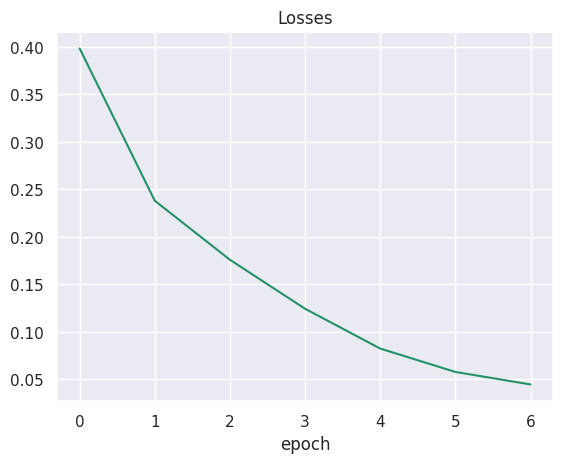

Лучшая accuracy: 89.92


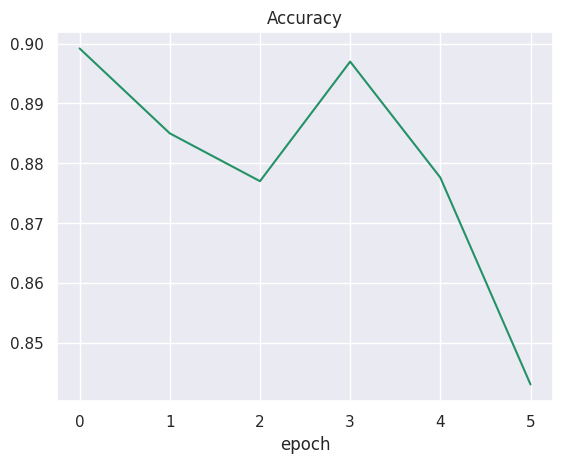

In [60]:
plt.plot(np.arange(len(losses_type)), losses_type)

plt.title('Losses')
plt.xlabel('epoch')
plt.show()

plt.plot(np.arange(len(acc_type[1:])), acc_type[1:])
print(f"Лучшая accuracy: {(max(acc_type) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.show()

In [61]:
kernel_sizes = [2, 3, 4]
vocab_size = len(vocab) + 1
out_channels = 64
dim = 300


model = TextCNN(vocab_size=vocab_size,
            emb_dim=dim,
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)



PATH = "/content/TextCNN"
model.load_state_dict(torch.load(PATH))
model.to(device)
print('Classification report for {}'.format(PATH.split('/')[-1]))
make_metrics(model, test_dataloader, name_mod=False)

Classification report for TextCNN


  0%|          | 0/157 [00:00<?, ?it/s]

Mean accuracy: 0.8938000202178955
              precision    recall  f1-score   support

       World       0.91      0.89      0.90      1270
      Sports       0.95      0.95      0.95      1206
    Business       0.86      0.87      0.86      1259
    Sci/Tech       0.87      0.86      0.86      1265

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



# Выводы

In [62]:
pd.DataFrame(models_stats, index=[0]).T.reset_index().rename(columns={'index':'model', 0:'mean_acc'}).sort_values(by='mean_acc')

model  mean_acc
9   SimpleLSTMBidirectional_bidir_4layers_mean   0.65920
17   SimpleGRUBidirectional_bidir_4layers_mean   0.68540
13                      SimpleGRU_4layers_mean   0.75660
5                      SimpleLSTM_4layers_mean   0.78380
0                                   CharLM_max   0.82176
11                       SimpleGRU_simple_mean   0.82860
1                                  CharLM_mean   0.83376
3                       SimpleLSTM_simple_mean   0.85360
15           SimpleGRUBidirectional_bidir_mean   0.87260
7           SimpleLSTMBidirectional_bidir_mean   0.88300
18                                     TextCNN   0.89380
4                       SimpleLSTM_4layers_max   0.91080
12                       SimpleGRU_4layers_max   0.91140
10                        SimpleGRU_simple_max   0.91240
2                        SimpleLSTM_simple_max   0.91320
8    SimpleLSTMBidirectional_bidir_4layers_max   0.91560
16    SimpleGRUBidirectional_bidir_4layers_max   0.91680
14            SimpleGRUBidirectional_bidir_max   0.91700
6            SimpleLSTMBidirectional_bidir_max   0.91940

По результатам исследования, можно сделать следующие выводы:
- Bidirectional модели показывают стабильно лучшие результаты;
- Увеличение количества слоев не приводит к стабильному росту результатов;
- При использовании базовой архитектуры, различия между GRU и LSTM практически отсутствуют;
- RNN модели лучше справляются с задачей, чем CNN.

Лучшее accuracy достигнуто на моделий SimpleLSTMBidirectional_bidir_max	и составляет 0.91940